<a href="https://colab.research.google.com/github/NishithaThimmappa/Coursera_projects/blob/main/Transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

- Examine and understand the data
- Build an input pipeline, in this case using Keras ImageDataGenerator
- Compose the model
  -  Load in the pretrained base model (and pretrained weights)
  - Stack the classification layers on top
- Train the model
- Evaluate model

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [8]:
url_='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip=tf.keras.utils.get_file('cats_and_dogs.zip', origin=url_, extract=True)

In [9]:
path=os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [10]:

train_dir=os.path.join(path, 'train')
validation_dir=os.path.join(path, 'validation')

batch_size=32
img_size=(160,160)

train_dataset=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset=tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [11]:
class_names=train_dataset.class_names
print(class_names)

['cats', 'dogs']


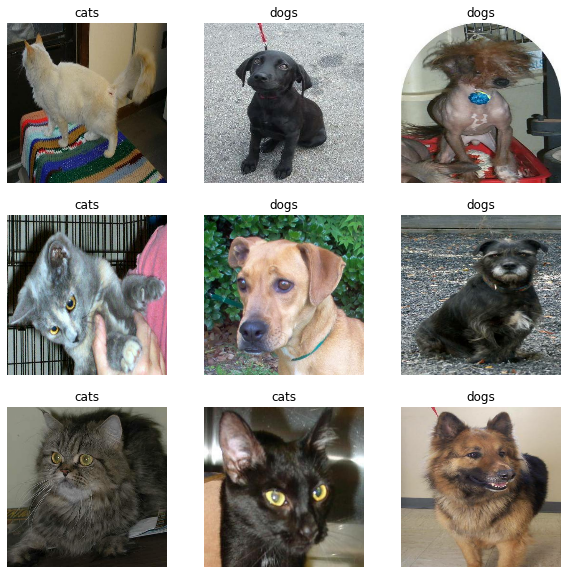

In [12]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

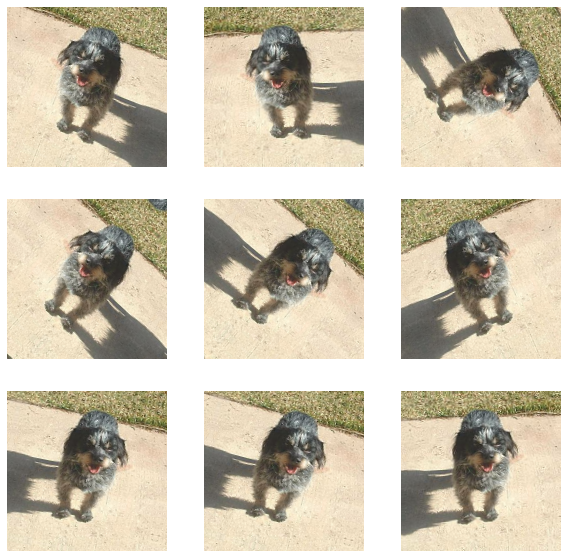

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Feature extraction

In [22]:
base_model.trainable = False

In [23]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [29]:
len(model.trainable_variables)

2

In [30]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 18s 555ms/step - loss: 0.7408 - accuracy: 0.5062


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.74
initial accuracy: 0.51


In [32]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 58s 855ms/step - loss: 0.6597 - accuracy: 0.5910 - val_loss: 0.5000 - val_accuracy: 0.7314
Epoch 2/10
63/63 [==============================] - 62s 984ms/step - loss: 0.4821 - accuracy: 0.7415 - val_loss: 0.3658 - val_accuracy: 0.8366
Epoch 3/10
63/63 [==============================] - 57s 891ms/step - loss: 0.3932 - accuracy: 0.8055 - val_loss: 0.2951 - val_accuracy: 0.8713
Epoch 4/10
63/63 [==============================] - 51s 816ms/step - loss: 0.3431 - accuracy: 0.8315 - val_loss: 0.2379 - val_accuracy: 0.9097
Epoch 5/10
63/63 [==============================] - 52s 817ms/step - loss: 0.2888 - accuracy: 0.8765 - val_loss: 0.2053 - val_accuracy: 0.9282
Epoch 6/10
63/63 [==============================] - 52s 822ms/step - loss: 0.2654 - accuracy: 0.8875 - val_loss: 0.1812 - val_accuracy: 0.9332
Epoch 7/10
63/63 [==============================] - 72s 1s/step - loss: 0.2541 - accuracy: 0.8895 - val_loss: 0.1615 - val_accuracy: 0.9455
Ep

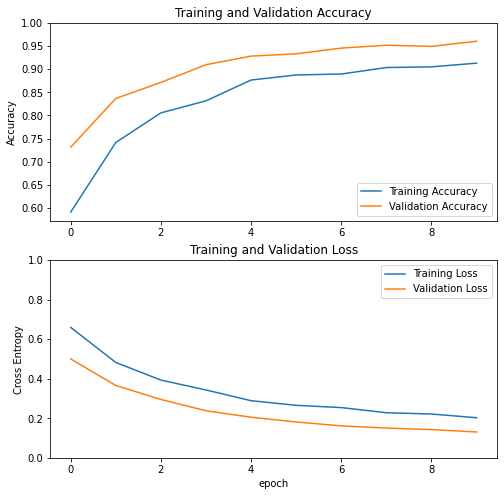

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning

In [34]:
base_model.trainable = True

In [35]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [38]:
len(model.trainable_variables)

56

In [39]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 86s 1s/step - loss: 0.1567 - accuracy: 0.9265 - val_loss: 0.0632 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 75s 1s/step - loss: 0.1242 - accuracy: 0.9465 - val_loss: 0.0480 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 76s 1s/step - loss: 0.0961 - accuracy: 0.9580 - val_loss: 0.0372 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 75s 1s/step - loss: 0.0976 - accuracy: 0.9590 - val_loss: 0.0351 - val_accuracy: 0.9864
Epoch 14/20
63/63 [==============================] - 74s 1s/step - loss: 0.0751 - accuracy: 0.9700 - val_loss: 0.0442 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 77s 1s/step - loss: 0.0794 - accuracy: 0.9700 - val_loss: 0.0385 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 76s 1s/step - loss: 0.0727 - accuracy: 0.9715 - val_loss: 0.0368 - val_accuracy: 0.9814
Epoch 17/20
6

In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

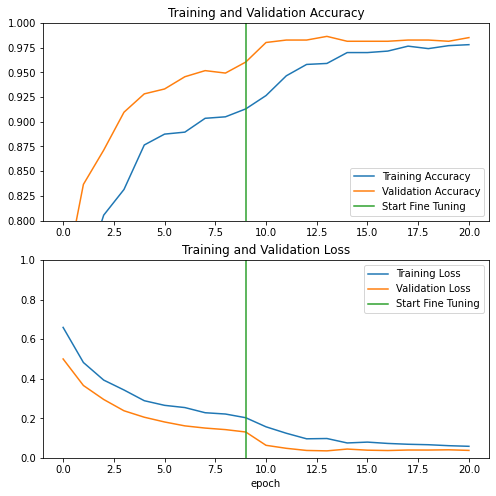

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
loss, accuracy=model.evaluate(test_dataset)
print('Test Accuracy', accuracy)

6/6 [==============================] - 3s 484ms/step - loss: 0.0412 - accuracy: 0.9792
Test Accuracy 0.9791666865348816


Predictions:
 [1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0]
Labels:
 [1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0]


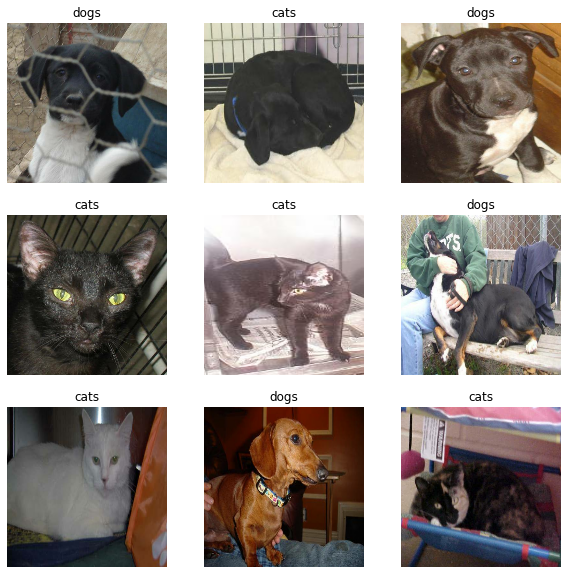

In [44]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")